In [1]:
import dascore as dc
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.fft import fft,fftfreq
from scipy.signal import find_peaks

In [2]:
# datapath = r'../Field Data/'
datapath = r"C:\Users\Tomas\Desktop\Martin Group\Field\11102023\2023_11_10_walktem_mag_fiber\UTC-YMD20231110-HMS214644.977" # background
sp = dc.spool(datapath)
sp.update()
sp.get_contents()

C:\Users\Tomas\anaconda3\envs\DASDAE\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Tomas\anaconda3\envs\DASDAE\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Tomas\anaconda3\envs\DASDAE\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Tomas\anaconda3\envs\DASDAE\lib\site-packages\dascore\utils\pd.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  unix_paths = series.str.replace(os.sep, "/")


,cable_id,d_distance,d_time,data_category,data_type,dims,distance_max,distance_min,file_format,file_version,instrument_id,network,path,station,tag,time_max,time_min
0,,1.633524,0 days 00:00:00.000162656,,velocity,"time, distance",89.84381,0.816762,TERRA15,5,TrebleIISystem04,,/2023_11_10_walktem_mag_fiber_velocity_UTC-YMD...,,,2023-11-10 22:11:50.724727040,2023-11-10 21:46:44.923440640
1,,1.633524,0 days 00:00:00.000162656,,velocity,"time, distance",89.84381,0.816762,TERRA15,5,TrebleIISystem04,,/2023_11_10_walktem_mag_fiber_velocity_UTC-YMD...,,,2023-11-10 22:12:13.292465664,2023-11-10 22:11:50.724889856


In [3]:
print(sp[0].attrs)

data_type='velocity' data_category='' data_units='m/s' time_min=numpy.datetime64('2023-11-10T21:46:44.923440640') time_max=numpy.datetime64('2023-11-10T22:11:50.724727040') d_time=numpy.timedelta64(162656,'ns') time_units='' distance_min=0.8167619070971258 distance_max=87.39352405939246 d_distance=1.6335238141942516 distance_units='' instrument_id='TrebleIISystem04' cable_id='' dims='time, distance' tag='' station='' network='' history=[]


In [4]:
print(sp[0].data.shape)


(9257472, 54)


In [5]:
bgtime = sp.get_contents()['time_min'][0]
edtime = sp.get_contents()['time_max'][0]
#bgtime+np.timedelta64(5,'m')
DASdata = sp.select(time=(bgtime,edtime))[0]
DASdata = DASdata.tran.velocity_to_strain_rate()
edtime-bgtime

Timedelta('0 days 00:25:05.801286400')

In [6]:
spectrogram_time = DASdata.select(time=(sp.get_contents()['time_min'][0],sp.get_contents()['time_max'][0])).tran.spectrogram().aggregate(dim='time',method='mean')


In [7]:
dir(spectrogram_time)
np.shape(spectrogram_time._data_array)

(129, 54, 1)

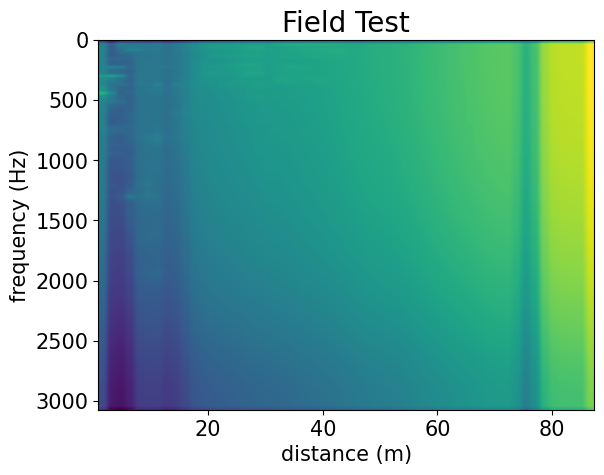

In [8]:
# creating a dictionary
font = {'size': 15}
 
# using rc function
plt.rc('font', **font)

plotdata = np.log(spectrogram_time.data[:,:,0])
xaxis = spectrogram_time.coords['distance']
yaxis = spectrogram_time.coords['ft_time']
plt.figure()
plt.imshow(plotdata,aspect='auto',extent=[xaxis[0],xaxis[-1],yaxis[-1],yaxis[0]])
plt.ylabel('frequency (Hz)',size=15)
plt.xlabel('distance (m)',size=15)
plt.title('Field Test',size=20)
plt.gca()
plt.show()

In [9]:
print(spectrogram_time)

<dascore.Patch (ft_time: 129, distance: 54, time: 1)>
array([[[8.21821435e-16],
        [1.51260933e-16],
        [5.02579005e-16],
        ...,
        [3.05834676e-13],
        [3.14488480e-13],
        [1.04550505e-12]],

       [[1.76184784e-14],
        [3.33764079e-15],
        [1.42273092e-14],
        ...,
        [6.73734245e-12],
        [6.86030963e-12],
        [2.27544372e-11]],

       [[1.55636273e-14],
        [2.29466858e-15],
        [8.89865794e-15],
        ...,
...
        ...,
        [4.79853028e-13],
        [4.85030202e-13],
        [1.63728840e-12]],

       [[1.02946002e-15],
        [1.23370613e-16],
        [1.01703855e-16],
        ...,
        [4.77076440e-13],
        [4.82713695e-13],
        [1.62585700e-12]],

       [[5.16021630e-16],
        [6.12308669e-17],
        [5.04433134e-17],
        ...,
        [2.37915644e-13],
        [2.42614847e-13],
        [8.12536561e-13]]], dtype=float32)
Coordinates:
  * ft_time   (ft_time) float64 0.0 24.02 48.0

In [10]:
sp[0].attrs['d_time']

numpy.timedelta64(162656,'ns')

In [58]:
## Get sampling rate (s)
df = 1/ (sp[0].attrs['d_time'].astype('float')*1e-9) 

#Channel index
ch = 15

# Spectrum using Welch method
f_1, spec_1 = signal.welch(DASdata.data[:,ch], df, 'flattop', scaling='spectrum',nperseg=int(4096/2))

peaks, _ = find_peaks(np.sqrt(spec_1),height=1e-7)

In [61]:
15*1.63

24.45

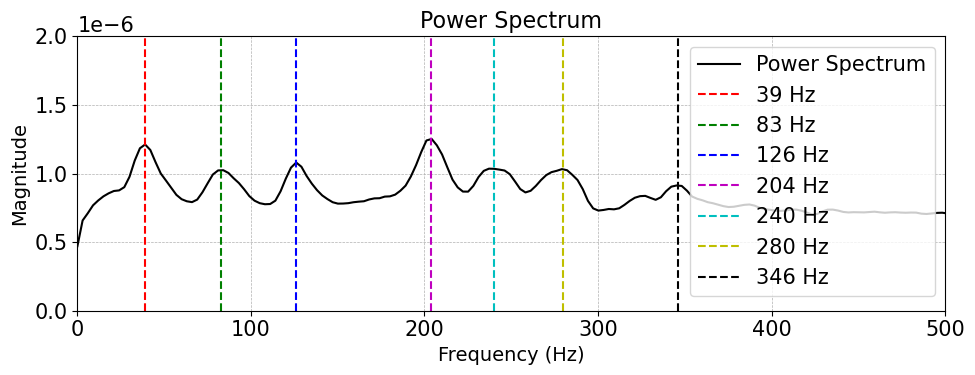

In [86]:
# Plot results
#%matplotlib notebook
fig, ax = plt.subplots(1,1, figsize=(10,4))

n = len(DASdata.data[:,ch])
tt = np.linspace(0,n,num=n)*sp[0].attrs['d_time'].astype('float')*1e-9
#ax[0].plot(tt,DASdata.data[:,ch],'k')
#ax[0].set_title('Time Series',fontsize=16)
#ax[0].set_ylim(-0.0001,0.0001)
#ax[0].set_xlim(10,10.05)
#ax[0].set_xlabel('Time (s)',fontsize=14)
#ax[0].set_ylabel('Strain rate',fontsize=14)

line = np.linspace(0,10e-6)
ax.plot(f_1, np.sqrt(spec_1),'k')
ax.plot(39*np.ones(np.size(line)),line,'r--')
ax.plot(83*np.ones(np.size(line)),line,'g--')
ax.plot(126*np.ones(np.size(line)),line,'b--')
ax.plot(204*np.ones(np.size(line)),line,'m--')
ax.plot(240*np.ones(np.size(line)),line,'c--')
ax.plot(280*np.ones(np.size(line)),line,'y--')
ax.plot(346*np.ones(np.size(line)),line,'k--')
ax.set_title('Power Spectrum',fontsize=16)
ax.set_ylim(0,2e-6)
ax.set_xlim(0,500)
ax.grid(linestyle='dashed',linewidth=0.5)
ax.set_xlabel('Frequency (Hz)',fontsize=14)
ax.set_ylabel('Magnitude',fontsize=14)
plt.tight_layout()
plt.legend(['Power Spectrum','39 Hz','83 Hz','126 Hz','204 Hz','240 Hz','280 Hz','346 Hz'])

# plt.savefig('Waveform_100Hz.png',dpi=300)
plt.show()

fig = plt.figure(figsize=(15,10))
time_window = np.timedelta64(30,'s')
time_interval = np.timedelta64(5,'s')
num_intervals = int((edtime-bgtime)/time_interval)-2*int(time_window/time_interval+1)
for i in range(1,num_intervals):
    m = np.timedelta64(i,'s')/time_interval
    MagData = sp.select(time=(bgtime+time_window*m,bgtime+time_window*(m+1)))[0]
    MagData = MagData.tran.velocity_to_strain_rate()
    
    # Get sampling rate (s)
    df = 1/ (sp[0].attrs['d_time'].astype('float')*1e-9) 

    #Channel index
    ch = 10

    # Spectrum using Welch method
    f_1, spec_1 = signal.welch(MagData.data[:,ch], df, 'flattop', scaling='spectrum',nperseg=int(4096/2))

    peaks, _ = find_peaks(np.sqrt(spec_1),height=1e-7)
    # Plot results
    #%matplotlib notebook
    #fig, ax = plt.subplots(1,2, figsize=(10,4))

    #n = len(MagData.data[:,ch])
    #tt = np.linspace(0,n,num=n)*sp[0].attrs['d_time'].astype('float')*1e-9
    #ax[0].plot(tt,MagData.data[:,ch],'k')
    #ax[0].set_ylim(-0.0001,0.0001)
    #ax[0].set_xlim(10,10.05)
    #ax[0].set_xlabel('Time (s)',fontsize=14)
    #ax[0].set_ylabel('Strain rate',fontsize=14)
    
    plt.plot(time_interval*i, np.sqrt(spec_1[int(np.size(spec_1)/4)]),'rs')
    plt.plot(time_interval*i, np.sqrt(spec_1[int(np.size(spec_1)/2)]),'bo')
    #ax[1].set_ylim(0,6e-7)

    plt.tight_layout()

    # plt.savefig('Waveform_100Hz.png',dpi=300)
plt.title('Power Spectrum Time Variation',fontsize=20)    
plt.grid()
plt.xlabel('Time (s)',fontsize=20)
plt.ylabel('Magnitude',fontsize=20)    
plt.legend(['1000 Hz','2000 Hz'])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tick_params(axis='both', which='major', labelsize=20)  # Adjust the font size here

#plt.yticks(fontsize=20)
#plt.xticks(fontsize=20)
#plt.rc('font', size=20)

In [13]:
spectrogram_distance = DASdata.select(distance=(15,20)).tran.spectrogram().aggregate(dim='distance',method='mean')

import datetime

t_array = spectrogram_distance.coords['time']
numeric_dates = (t_array - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')

plotdata = np.log(spectrogram_distance.data[:,0,:])
taxis = numeric_dates
faxis = spectrogram_distance.coords['ft_time']
plt.figure()
plt.imshow(plotdata,aspect='auto',extent=[taxis[0],taxis[-1],faxis[-1],faxis[0]])
plt.ylabel('frequency (Hz)')
plt.xlabel('time')
plt.title('Field Test')
plt.show()